<a href="https://colab.research.google.com/github/dongdong-e/Python/blob/master/%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC/03_%EA%B5%AD%EB%AF%BC%EC%B2%AD%EC%9B%90_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A1%9C_%EC%9D%B4%EC%A7%84_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **국민청원 데이터로 이진 분류하기**

* **예제로 응답여부를 0과 1로 예측**
* **응답여부 외에도 청원의 카테고리를 예측하는 분류도 가능**
* **이 예제를 참고하여 응답여부 외에 청원내용으로 평균 이상의 투표를 받을 것인지 예측**
* **파이썬의 머신러닝 라이브러리인 Scikit-learn을 사용**

In [0]:
import pandas as pd
import numpy as np
import re

---

## **데이터 로드하기**

In [0]:
# 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증을 합니다.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
url ='https://drive.google.com/open?id=1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4'
id = url.split('=')[1]

In [0]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어온다.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('petition.csv')  

In [0]:
petitions = pd.read_csv('petition.csv', parse_dates=['start', 'end'])

In [6]:
# 전체 데이터 중 투표가 500건 이상인 데이터를 기준으로 가져온다.
# 아웃라이어 데이터 제거를 위해 20만건 이상 데이터도 제거한다.
petition_remove_outliar = petitions[(petitions['votes'] > 500) & (petitions['votes'] < 200000)]

petition_remove_outliar.shape

(5109, 8)

In [0]:
df = petition_remove_outliar.copy()

---

# **이진분류 대상 정하기**

In [8]:
# 답변 대상건 갯수 확인하기
df[df['answered'] == 1].shape

(0, 8)

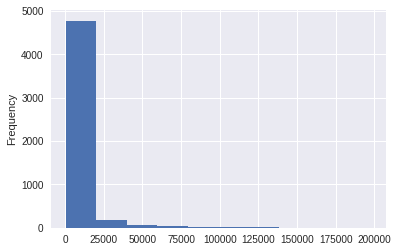

In [9]:
%matplotlib inline
df['votes'].plot.hist()

# 아래 그래프를 보면 청원 대부분이 25,000건 미만의 투표를 받은 것으로 확인할 수 있다.

---

# **투표수를 평균보다 높게 혹은 적게 받는지 예측해 보기**

In [0]:
# 기본값을 0으로 세팅
df['votes_pos_neg'] = 0

In [11]:
# 평균 투표수 구하기
votes_mean = df['votes'].mean()
votes_mean

5674.709140732041

In [0]:
# 투표수가 평균을 넘으면 1, 아니면 0으로 votes_pos_neg의 값 재설정
df['votes_pos_neg'] = (df['votes'] > votes_mean) == 1

In [13]:
df['votes_pos_neg'].dtype

dtype('bool')

In [0]:
# 위에 타입이 'bool' 타입이므로 'int' 타입으로 변경
df['votes_pos_neg'] = df['votes_pos_neg'].astype('int')

In [15]:
# 평균값 = 5674.709140732041
df[['votes', 'votes_pos_neg']].head()

,votes,votes_pos_neg
7,2137,0
13,679,0
21,11293,1
24,1933,0
28,1251,0


In [0]:
# 샘플로 보고 싶은 인덱스 번호 추가
sample_index = 13

In [17]:
sample_title = df.loc[sample_index, 'title']
sample_title

'『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 문제점 개선 청원'

In [18]:
sample_content = df.loc[sample_index, 'content']
sample_content

'(현황)\\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨 을 바쳐 대한민국을 지켜내는데 헌신했습니다. 우리들 대부분의 아버님들 중 12만위는 전쟁 후 지금껏 유해도 수습 못했고 忌日도 제대로 알지 못하지만 오직 국가유공자의 자녀라는 자긍심으로 오랜 기간을 가난과 멸시 천대를 이겨왔습니다.\\n전후 원호제도는 빈약하여 전사자와 그 가족에 대한 보상과 연금 등은 너무 빈약했고,  그 후도 경제발전 수준을 따라가지도 못하였는데, 1960년대 말은 전쟁유자녀가 성년이 되었다는 이유로 보훈 보상혜택에서 제외시켰다가 김대중정부 시절 2001년7월부터 보훈제도가 확대되어 전후의 미흡했던 보훈혜택을 보전해주기 위해 1997년 12월31일을 기준으로 아래의 제적유자녀 1)와 승계유자녀 2)에게는 先順位자녀 1人에 대하여만「6ㆍ25전몰 군경자녀수당」을 지급하게 되었으나, 단서조항으로 1998년1월1일 이후 어머니 사망으로 연금수급권이 소멸되기 시작한 저희 유자녀들에 대하여는 동법 적용을 배제하여, 어머니 돌아가신 날 하루 차이로 “미수당유자녀” 아래표 3)라는 보훈정책의 사각지대가 생겨났던 것입니다.\\n신설된 수당과 유족연금이 노무현 정부이래 점차 현실화 인상 조정되고 이 문제가 장기간 누증되다보니\\n6.25전쟁에서 똑 같이 아버지가 전사한 군·경유자녀들인데, 누구는 국가의 지원을 받고 누구는 국가의 지원을 받지 못하는 형평성에 문제가 있는 『국가유공자 등 예우 및 지원에 관한 법률』제16조3(6.25자녀수당)의1,(단서조항 : 1998년 1월 1일을 삭제하는 법안)을 19대 국회에서 더민주당 민홍철 의원님(경남 김해)이 2014년 2월 대표발의 하시어 당시 여당의원 일부 반대의 우여곡절 끝에 전해철 법사위 소위원장님 등의 주도적 노력으로 2015년 11월30일 제337회 정기회에서 재석 의원 만장일치로 법이 통과되어 12월29일 법률 제13697호로 공포된바 있었습니다.\\n그럼에도 박근혜 정부는 동법 개정이유와 주요내용에서 입법부가 

---

# **전처리 하기**

In [0]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    
    # 특수문자 제거
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    
    # 한글, 영문, 숫자만 남기고 모두 제거
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub(' +', ' ', text)
    return text

In [0]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['안녕', '있습니다', '그', '년도', '안녕하세요', '하는', '및', '제', '할',
             '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일',
             '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [21]:
# 샘플데이터에 적용
%time pre_sample_content = preprocessing(sample_content)

CPU times: user 4.57 ms, sys: 0 ns, total: 4.57 ms
Wall time: 4.84 ms


In [22]:
%time pre_sample_content = remove_stopwords(pre_sample_content)

CPU times: user 1.07 ms, sys: 0 ns, total: 1.07 ms
Wall time: 1.86 ms


In [23]:
pre_sample_content

' 현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨 을 바쳐 대한민국을 지켜내는데 헌신했습니다 우리들 대부분의 아버님들 중 만위는 전쟁 후 지금껏 유해도 수습 못했고 도 제대로 알지 못하지만 오직 국가유공자의 자녀라는 자긍심으로 오랜 기간을 가난과 멸시 천대를 이겨왔습니다 전후 원호제도는 빈약하여 전사자와 가족에 보상과 연금 등은 너무 빈약했고 후도 경제발전 수준을 따라가지도 못하였는데 년대 말은 전쟁유자녀가 성년이 되었다는 이유로 보훈 보상혜택에서 제외시켰다가 김대중정부 시절 년 월부터 보훈제도가 확대되어 전후의 미흡했던 보훈혜택을 보전해주기 년 일을 기준으로 아래의 제적유자녀 와 승계유자녀 에게는 자녀 에 대하여만 전몰 군경자녀수당 을 지급하게 되었으나 단서조항으로 년 이후 어머니 사망으로 연금수급권이 소멸되기 시작한 저희 유자녀들에 대하여는 동법 적용을 배제하여 어머니 돌아가신 날 하루 차이로 미수당유자녀 아래표 라는 보훈정책의 사각지대가 생겨났던 것입니다 신설된 수당과 유족연금이 노무현 정부이래 점차 현실화 인상 조정되고 이 문제가 장기간 누증되다보니 전쟁에서 똑 같이 아버지가 전사한 군 경유자녀들인데 누구는 국가의 지원을 받고 누구는 국가의 지원을 받지 못하는 형평성에 문제가 있는 국가유공자 예우 지원에 관한 법률 조 자녀수당 의 단서조항 년 일을 삭제하는 법안 을 대 국회에서 더민주당 민홍철 의원님 경남 김해 이 년 대표발의 하시어 당시 여당의원 일부 반대의 우여곡절 끝에 전해철 법사위 소위원장님 등의 주도적 노력으로 년 회 정기회에서 재석 의원 만장일치로 법이 통과되어 법률 호로 공포된바 있었습니다 그럼에도 박근혜 정부는 동법 개정이유와 주요내용에서 입법부가 제안한대로 특정일 기준 없이 전몰군경유자녀에게 자녀수당을 지급하도록 하여 자녀간 형평성을 도모함과 이들에 생활안정과 복지향상을 재고하려 고 밝히면서도 입법부의 개정 법률에 정면 위배되는 시행령 호 으로 천원 천원 천원이라는 불평등으로 호국영령의 명예와 최장 여

In [0]:
df['content_preprocessing'] = df['content'].apply(preprocessing)

In [0]:
df['content_preprocessing'] = df['content_preprocessing'].apply(remove_stopwords)

---

# **학습세트와 테스트세트 만들기**
* **학습세트와 테스트세트를 7:3 비율로 설정**

In [26]:
df = df.reset_index()
df.head(3)

,index,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing
0,7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,0,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니다 중...
1,13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨...
2,21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",1,대통령님 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 했을 때 공채 채...


In [27]:
df.shape

(5109, 11)

## **데이터를 나누는 기준을 구함**

In [0]:
split_count = int(df.shape[0] * 0.7)

## **학습세트 만들기**
* **split_count를 기준으로 70% 분량만 데이터로 활용**

In [29]:
df_train = df[:split_count].copy()
df_train.shape

(3576, 11)

In [30]:
# 학습세트에서 투표수가 평균보다 많은 건
df_train.loc[df_train['votes_pos_neg'] == 1].shape

(671, 11)

## **테스트세트 만들기**
* **split_count를 기준으로 30% 분량만 데이터로 활용**

In [31]:
df_test = df[split_count:].copy()
df_test.shape

(1533, 11)

In [32]:
df_test.head(1)

,index,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing
3576,264134,343214,2018-08-15,2018-09-14,0,724,교통/건축/국토,"동탄1 신도시의 동탄트램1호선, 동탄트램2호선을 유지하여 착공해주세요",청원개요\n존경하는 대통령님\n동탄 1신도시는 국가의 중추를 담당하는 허리로써\n인...,0,청원개요 존경하는 대통령님 동탄 신도시는 국가의 중추를 담당하는 허리로써 인구 만에...


In [33]:
# 테스트세트에서 투표수가 평균보다 많은 건
df_test.loc[df_test['votes_pos_neg'] == 1].shape

(273, 11)

---

# **단어 벡터화하기**

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word',      # 캐릭터 단위로 벡터화 가능
                              tokenizer = None,     # 토크나이저를 따로 지정 가능
                              preprocessor = None,  # 전처리 도구
                              stop_words = None,    # 불용어 nltk 등의 도구를 사용 가능
                              min_df = 2,           # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문 용어
                              ngram_range = (1, 3), # BOW의 단위를 1 ~ 3개로 지정
                              max_features = 2000   # 만들 피처 수, 단어의 수
                             )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [35]:
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing'])
train_feature_vector.shape

(3576, 2000)

In [36]:
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing'])
test_feature_vector.shape

(1533, 2000)

In [37]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'article',
 'articleview',
 'articleview html',
 'articleview html idxno',
 'a는',
 'a의',
 'a형',
 'b형',
 'cctv']

In [38]:
dist = np.sum(train_feature_vector, axis = 0)
pd.DataFrame(dist, columns = vocab)

,aid,article,articleview,articleview html,articleview html idxno,a는,a의,a형,b형,cctv,...,훨씬,희망을,힘든,힘들게,힘들고,힘들어,힘듭니다,힘없는,힘을,힘이
0,123,100,77,108,84,84,58,264,256,116,...,75,128,81,210,129,60,55,53,119,95


---

## **TF-IDF 가중치 적용**

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf = False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [40]:
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

(3576, 2000)

In [41]:
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

(1533, 2000)

---

## **랜덤 포레스트로 학습시키기**

In [42]:
from sklearn.ensemble import RandomForestClassifier

# '랜덤 포레스트' 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state = 42
)

forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
# 학습에 사용할 y_label을 넣어준다.
y_label = df_train['votes_pos_neg']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 7.33 s, sys: 14.8 ms, total: 7.35 s
Wall time: 3.77 s


---

## **평가하기**

In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)

scoring = 'accuracy'
score = cross_val_score(forest, train_feature_tfidf,
                       y_label, cv = k_fold, n_jobs = -1,
                       scoring = scoring)

score

array([0.79608939, 0.81678322, 0.81818182, 0.81258741, 0.81118881])

---

## **예측**

In [45]:
# 테스트 데이터를 넣고 예측한다.
y_pred = forest.predict(test_feature_tfidf)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
# 예측 결과를 데이터프레임에 담아준다.
output = pd.DataFrame(data = {'votes_pos_neg_pred':y_pred})
output.head()

,votes_pos_neg_pred
0,0
1,0
2,0
3,0
4,0


In [0]:
df_test['votes_pos_neg_pred'] = y_pred

---

## **예측 결과 정확도 보기**

In [48]:
df_test['pred_diff'] = np.abs(df_test['votes_pos_neg'] - df_test['votes_pos_neg_pred'])
df_test[['title', 'votes', 'votes_pos_neg', 'votes_pos_neg_pred', 'pred_diff']].head()

,title,votes,votes_pos_neg,votes_pos_neg_pred,pred_diff
3576,"동탄1 신도시의 동탄트램1호선, 동탄트램2호선을 유지하여 착공해주세요",724,0,0,0
3577,어린이집학부모 모니터링과 평가인증 없애야한다고 생각합니다 .,507,0,0,0
3578,"국방부 ""해안·강 경계철책 300㎞ 중 절반 단계적 철거"" 대한민국 안전을 위협합니다.",558,0,0,0
3579,인천 미추홀구(남구) 악취로 인해 못살겠습니다~,1322,0,0,0
3580,시민단체수준인 여가부 폐지를 청원합니다,1371,0,0,0


In [49]:
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    1253
1     280
Name: pred_diff, dtype: int64

In [50]:
print('전체 {}건의 데이터 중에서 {}건 예측'.format(y_pred.shape[0], pred_diff[0]))

전체 1533건의 데이터 중에서 1253건 예측
